In [1]:
%matplotlib inline
# %matplotlib notebook # Does not work 
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import json
from hpbandster.core.result import logged_results_to_HBS_result
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os
import sys

# yup

In [2]:
def open_hpo_results_files(file):
    with open(file, 'rt') as f_in:
        raw = []
        for line in f_in:
            raw.append(json.loads(line))
        return raw

In [3]:
def load_hpo_results(results_dir):
    results_file = results_dir + 'results.json'
    config_file = results_dir + 'configs.json'
    return {
        'results_dir': results_dir,
        'results_lines': open_hpo_results_files(results_file),
        'config_lines': open_hpo_results_files(config_file)        
        }

In [4]:
def load_results(file):
    with open(file, 'rt') as f_in:
        results = []
        for line in f_in:
#             line = line.strip('\n')
            results.append(json.loads(line))
        
        losses = [x[3]['loss'] for x in results if x[1] == 100] # Get only runs on 100% of data
        
        print(file)
        print('Length results: ', len(losses))
        
#         if 's1' in x[3]['info'].keys():
#             fold = 's1'
#         else:
#             fold = 's'

        if 's1' in results[0][3]['info'].keys():
            fold = 's1'
        else: 
            fold = 's'

        out_dict = {'loss_data': losses,
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
                'times': [x[2] for x in results if x[1] == 100],
                'configs': [x[0] for x in results if x[1] == 100],
                'model_file': [x[3]['info'][fold]['info']['model_file'] for x in results if x[1] == 100],
                'file': file
               }
        
        if 'test_results' in results[0][3]['info'][fold]['info'].keys():
            out_dict['test_results']: [x[3]['info'][fold]['info']['test_results'] for x in results if x[1] == 100]
            
    return out_dict

In [5]:
def plot_results(dataset, hpo_method, *plots, dev_def=0, test_def=0, n=0, n_lim=0, time_flag=False):

    plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()

    plt.title(dataset.upper() + ' HPO validation set' )
    
    plt.axhline(y=dev_def, color='r', linestyle='-', label = 'Val default hp')
    plt.axhline(y=test_def, color='g', linestyle='--', label = 'Test default hp')
    
    for plot_data in plots:
    
        len_data = len(plot_data['loss_data'])
        
        if (n_lim < len_data) and (n_lim > 0):
            n_up = n_lim
        else:
            n_up = len_data        
        
        pp = PdfPages(dataset + '_hpo_curve.pdf')
        pp.savefig()
#         y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
#         min_losses = get_min_loss(plot_data['loss_data'])
    
    
        metric_max_avg = [1 - x for x in plot_data['loss_data']]
#         metric_max = [1 - x for x in min_losses]

        duration = plot_data['times'][n_up-1]['finished'] - plot_data['times'][0]['submitted']
        
        print('Duration: ', round(duration/3600,2), 'hrs')
    
        if time_flag:
            initial = plot_data['times'][0]['submitted']

#             idx = list(np.linspace(0, time_diff, num=len(metric_max_avg)))
            idx = [x['finished'] - initial for x in plot_data['times']]
        
            idx = [x/3600 for x in idx]
            plt.xlabel('wallclock-time [hr]', fontsize = 13)
        else:
            idx = list(range(0,len(metric_max_avg)))
            plt.xlabel('# function evaluations', fontsize = 13)
        
        if dataset == 'tvqa':            
            plt.ylabel('Loss/Accuracy', fontsize = 13)
        else:
            plt.ylabel('Loss/MAP', fontsize = 13)
        
        
        metric_max_avg_sliced = metric_max_avg[n:n_up]
#         metric_raw_sliced = metric_raw[n:n_up]
        
        x_idx = idx[n:n_up]
        
        p = plt.plot(x_idx, metric_max_avg_sliced, label = hpo_method.upper())
        
        
        y = np.asarray(metric_max_avg_sliced)
        error = np.asarray(plot_data['min_std'])
        plt.fill_between(x_idx, y-error, y+error, alpha=0.3)
        
#         print(p[0].get_color())
        
#         if raw_flag: # There is no raw data with average, because I'm plotting the average of the max
#             plt.plot(x_idx, metric_raw_sliced, label = 'Raw '+ hpo_method.upper(), color=p[0].get_color(), alpha=0.3)
# #             plt.plot(x_idx, metric_raw_sliced, label = 'Raw '+ hpo_method.upper(), alpha=0.3)
#             raw_y = np.asarray(metric_raw_sliced)
#             raw_error = np.asarray(plot_data['std'])
# #             plt.fill_between(x_idx, raw_y-raw_error, raw_y+raw_error, alpha=0.3)
        
#     plt.plot([x/hour for x in incumbent_bohb['times_finished']], incumbent_bohb['losses'])
    pp.savefig()
    plt.legend()
    plt.show()
    pp.close()
    return [metric_max_avg, idx]

In [6]:
def get_best_config(*results_dirs):
    
    for results_dir in results_dirs:
        results = logged_results_to_HBS_result(results_dir)
        print( {'dir': results_dir,
                'config': results.get_id2config_mapping()[results.get_incumbent_id()]['config'],
                'mean_metric': results.get_runs_by_id(results.get_incumbent_id())[-1].info['mean_metric']
               }, '\n' )

In [7]:
now = datetime.now()
timestamp = datetime.timestamp(now)

In [8]:
def get_hpo_results_dir(workdir, hpo_method):
    
    results_dirs = []
    for root, dirs, files in os.walk(workdir, topdown=False):
        for name in dirs:
            if (hpo_method in name):
                results_dirs.append(os.path.join(root, name))
    return results_dirs

In [9]:
def get_min_loss(values):
    min_values = [min(values[0:i+1]) for i,x in enumerate(values)]
    return min_values

In [10]:
def get_avg_results(results_files):
    res = []
    
    for r in results_files:
        r_load = load_results(r)
#         if len(r_load['loss_data']) > 100: # Load results only if they are above 100 function evaluations. Need to concat wit the other one             
        if len(r_load['loss_data']) > 1: # Load results only if they are above 100 function evaluations. Need to concat wit the other one             
            res.append(r_load)                  
        else: 
            print('Do not plot. Too small sample: ', len(r_load['loss_data']))
            
        ## Borrar
#         print(r_load['loss_data'][0:10])
    
    min_len = min(len(r['loss_data']) for r in res)
    max_len = max(len(r['loss_data']) for r in res)
    
    ## Some stats 
    print('Min sample: ', min_len)
    print('Max sample: ', max_len)

    losess = [r['loss_data'][0:min_len] for r in res]
    
    indexes_min = [y.index(min(y)) for y in losess] 
    
    file_stats_max = [['./' + a['file'].split('/')[-2] + '/',  a['model_file'][b], 'Metric: ', round(1 - a['loss_data'][b],4)] for a,b in zip(res, indexes_min)]
    
    max_metric_config = max(file_stats_max, key=lambda x: x[2])
    
    print('Max metric: \n', max_metric_config)
    
    
    
    min_losess = [get_min_loss(r['loss_data'][0:min_len]) for r in res]
    
#     min_losess_mean = [np.mean(list(i)) for i in zip(*losess)]
    min_losess_mean = [np.mean(list(i)) for i in zip(*min_losess)]
    
    mean_loss = [np.mean(list(i)) for i in zip(*losess)]
    
    std = [np.std(list(i)) for i in zip(*losess)]
    
    min_losess_std =  [np.std(list(i)) for i in zip(*min_losess)]
    

#     print(min_losess_mean[0:10])
#     return {'loss_data': mean_loss, # According to the least number of observations
    return {'loss_data': min_losess_mean, # According to the least number of observations
            'std': std,
            'min_std': min_losess_std,
            'max_metric': max_metric_config,
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
            
            'times': res[0]['times'][0:min_len] # Time reference of the first run, not the ebst way!
           }



###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb/results.json
Length results:  1074
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1573636293/results.json
Length results:  1500
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1573758626/results.json
Length results:  869
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1573820947/results.json
Length results:  870
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1573848102/results.json
Length results:  962
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_bohb_1574032883/results.json
Length results:  443
Min sample:  443
Max sample:  1500
Max metric: 
 ['./hpo_results_bohb/', './bioasq_dir/bioasq_lmart_id125_budget100_leaves75_lr0.08_n550', 'Metric: ', 0.4489]
Duration:  17.62 hrs


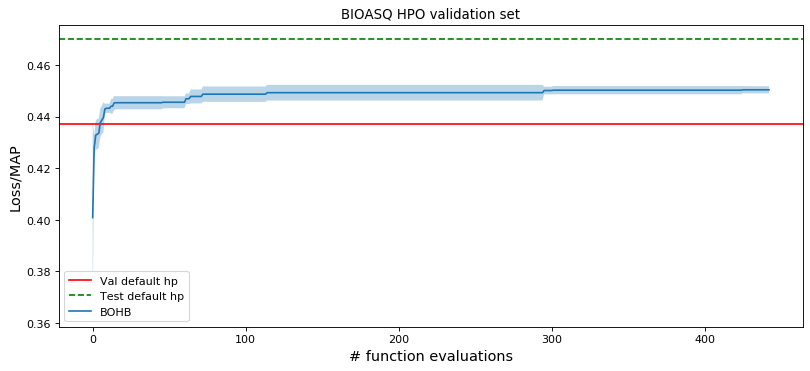



###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_rs_1573636254/results.json
Length results:  1000
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_rs/results.json
Length results:  1000
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_rs_1573757525/results.json
Length results:  2000
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_rs_1573820144/results.json
Length results:  1000
./deep-relevance-ranking/models/baselines/bioasq_dir/hpo_results_rs_1573848109/results.json
Length results:  1000
Min sample:  1000
Max sample:  2000
Max metric: 
 ['./hpo_results_rs_1573636254/', './bioasq_dir/bioasq_lmart_id401_budget100_leaves15_lr0.07_n1800', 'Metric: ', 0.4518]
Duration:  18.78 hrs


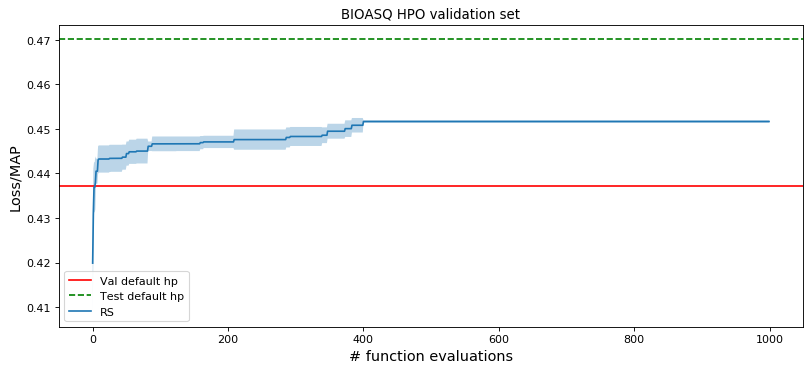



###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1573765824/results.json
Length results:  186
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb/results.json
Length results:  298
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1573636384/results.json
Length results:  131
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1573718146/results.json
Length results:  177
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_bohb_1574004561/results.json
Length results:  108
Min sample:  108
Max sample:  298
Max metric: 
 ['./hpo_results_bohb_1573765824/', './robust_dir/s1/robust_s1_lmart_id441_budget100_leaves20_lr0.13_n590', 'Metric: ', 0.2403]
Duration:  13.37 hrs


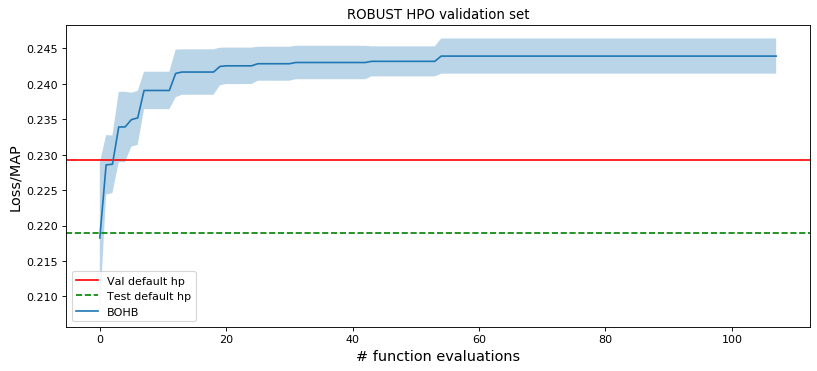



###############################
####### New Graph #############

./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_rs_1573636396/results.json
Length results:  272
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_rs_1573718156/results.json
Length results:  227
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_rs_1573954581/results.json
Length results:  173
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_rs/results.json
Length results:  499
./deep-relevance-ranking/models/baselines/robust_dir/hpo_results_rs_1573765785/results.json
Length results:  291
Min sample:  173
Max sample:  499
Max metric: 
 ['./hpo_results_rs_1573636396/', './robust_dir/s1/robust_s1_lmart_id331_budget100_leaves35_lr0.03_n1500', 'Metric: ', 0.2443]
Duration:  14.57 hrs


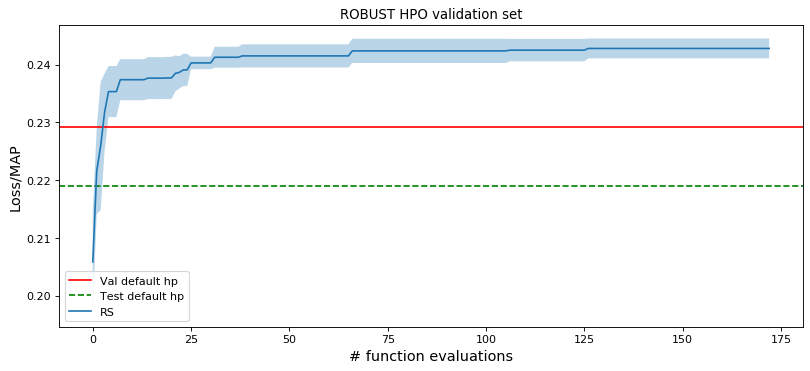



###############################
####### New Graph #############

./TVQA/workdir/hpo_results_bohb/results.json
Length results:  120
./TVQA/workdir/hpo_results_bohb_1573570289/results.json
Length results:  717
./TVQA/workdir/hpo_results_bohb_1574003537/results.json
Length results:  206
./TVQA/workdir/hpo_results_bohb_1573954316/results.json
Length results:  183
Min sample:  120
Max sample:  717
Max metric: 
 ['./hpo_results_bohb/', './workdir/tvqa_lmart_id46_budget100_leaves35_lr0.14_n1900', 'Metric: ', 0.5556]
Duration:  13.39 hrs


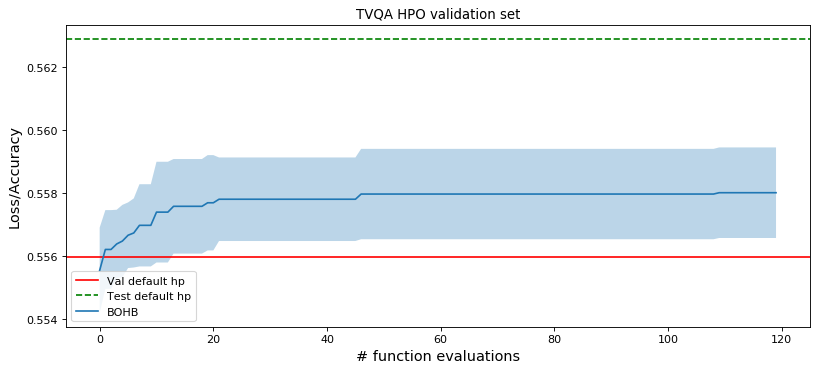



###############################
####### New Graph #############

./TVQA/workdir/hpo_results_rs/results.json
Length results:  201
./TVQA/workdir/hpo_results_rs_1573570296/results.json
Length results:  281
./TVQA/workdir/hpo_results_rs_1574003525/results.json
Length results:  129
./TVQA/workdir/hpo_results_rs_1573954349/results.json
Length results:  198
./TVQA/workdir/hpo_results_rs_1574034451/results.json
Length results:  141
Min sample:  129
Max sample:  281
Max metric: 
 ['./hpo_results_rs/', './workdir/tvqa_lmart_id19_budget100_leaves90_lr0.16_n1400', 'Metric: ', 0.5565]
Duration:  8.89 hrs


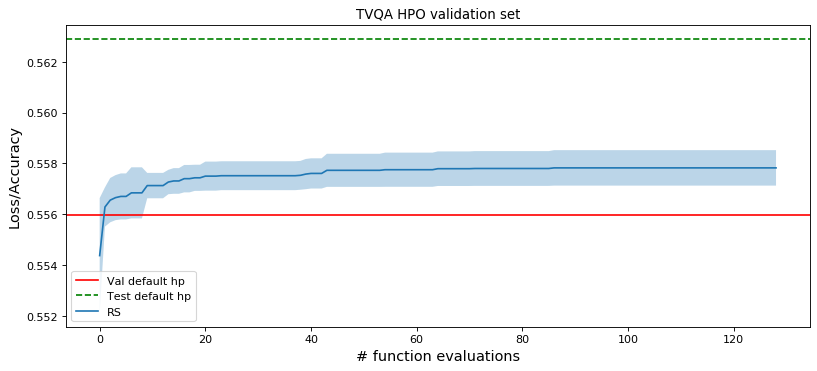

In [11]:
# For each dataset and hpo method


workdirs = [ 
            './deep-relevance-ranking/models/baselines/bioasq_dir/',
            './deep-relevance-ranking/models/baselines/robust_dir/',
            './TVQA/workdir/'
           ]
dev_defaults = [
                0.4371,
                0.2292,
                0.55597
               ]

test_defaults = [
                0.4703,
                0.2189,
                0.56291
               ]

hpo_methods = [
                'bohb', 
                'rs'
]

for wdir, dev_def, test_def in zip(workdirs, dev_defaults, test_defaults):
    
    for h in hpo_methods:
        print('\n\n###############################\n####### New Graph #############\n')
        # Get results_dir
        results_dirs = get_hpo_results_dir(wdir, h)

#         print(results_dirs)
        # Get mean, std
        results_files = [x + '/results.json' for x in results_dirs]

        if 'bioasq' in wdir.lower():
            dataset = 'bioasq'
        elif 'robust' in wdir.lower():
            dataset = 'robust'
        elif 'TVQA'.lower() in wdir.lower():
            dataset = 'tvqa'
        
#         print(dataset)
        avg_res = get_avg_results(results_files)
        n_limit = len(avg_res['loss_data'])
    
        [max_m, idx] = plot_results(dataset, h, avg_res, dev_def=dev_def, test_def=test_def, n=0, n_lim=n_limit, time_flag=False)

        # Plot

        # Save results all results